In [122]:
import os

QM9_path = os.environ["DATA"] + "/00_datasets/DFT/QM9/filtered_QM9_charges_radicals_stereo.smi"
# ChEMBL_CNOF_path = os.environ["DATA"] + "/00_datasets/ChEMBL25/filtered_ChEMBL_charges_radicals_stereo_CNOF.smi"
json_cache_location = os.environ["DATA"] + "/00_datasets/DFT/QM9/cache_QM9.json"


output_fig_path = os.environ["FIGURES"] + "/07_BBO/02_models/these/HOMO/04.01_HOMO_prediction_v2_thèse_save_intramodel_error/"
output_data_path = os.environ["DATA"] + "/07_BBO/02_models/these/HOMO/v2_thèse_save_intramodel_error/03.01_HOMO_prediction/"

N_JOBS = 10

dft_path = "/tmp"
os.makedirs(output_fig_path, exist_ok=True)
os.makedirs(output_data_path, exist_ok=True)

In [123]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct

kernels = [
    ("RBF", 1.0*RBF(1.0)),
    ("DotProduct", 1.0*DotProduct(1.0))
]

In [124]:
import csv
from evomol.evaluation import QEDEvaluationStrategy
from evomol.evaluation_dft import OPTEvaluationStrategy
import numpy as np

def load_smiles_dataset(path):
    
    all_smiles = []
    
    with open(path, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            all_smiles.append(row[0])
            
    np.random.shuffle(all_smiles)
    return all_smiles
        

def compute_QED(dataset_smiles):
    
    s = QEDEvaluationStrategy()
    return [s.eval_smi(smi) for smi in dataset_smiles]

In [125]:
QM9_smiles = load_smiles_dataset(QM9_path)
# ChEMBL_smiles = load_smiles_dataset(ChEMBL_CNOF_path)

print(len(QM9_smiles))
# print(len(ChEMBL_smiles))

132040


In [126]:
import numpy as np

def gen_splits(size, n_splits):
    
    for i in range(n_splits):
        
        train_idx = np.arange(i*size, i*size + size)
        test_idx = np.array(np.setdiff1d(np.arange(n_splits*size), train_idx))
        yield train_idx, test_idx
        

In [145]:
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from chemdesc.descriptors import ShinglesVectDesc, MBTRDesc
from tqdm import tqdm
import time
from sklearn.model_selection import cross_validate


def procedure(complete_smiles_list, kernels, alpha_values, test_on=None):
    
    
    desc_builder_shingles = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    desc_builder_mbtr = MBTRDesc(cache_location=None, n_jobs=N_JOBS, cosine_angles_n=25, atomic_numbers_n=10, 
                                 inverse_distances_n=25, species=["C", "H", "O", "N", "F"], 
                                 MM_program="rdkit")
    
    eval_strat = OPTEvaluationStrategy("homo", n_jobs=2, cache_files=[json_cache_location], 
                                       working_dir_path=dft_path, MM_program="rdkit")
    
    
    output_dict = {}
    
    smiles_list = complete_smiles_list[:100000]
    
#     smiles_list = complete_smiles_list[:100]
   


    X_shingles = desc_builder_shingles.fit_transform(smiles_list)[0]
    X_mbtr = desc_builder_mbtr.fit_transform(smiles_list)[0]
    y = np.array([eval_strat.eval_smi(smi) for smi in smiles_list])
    
    for kernel_tuple in kernels:
        
        if kernel_tuple[0] == "RBF":
            X = X_mbtr
        elif kernel_tuple[0] == "DotProduct":
            X = X_shingles
        else:
            print("neither")
    
        
        output_dict[kernel_tuple[0]] = {alpha: {} for alpha in alpha_values}
        
        
        for alpha_value in alpha_values:
            
            generator = gen_splits(1000, 100)
        
#             generator = gen_splits(10, 10)
        
            kernel = kernel_tuple[1]
            model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, alpha=alpha_value)

            results = cross_validate(model, X, y, scoring="neg_mean_absolute_error", cv=generator, 
                                     n_jobs=N_JOBS, return_estimator=True, verbose=10)
            
            output_dict[kernel_tuple[0]][alpha_value]["scores"] = list(results["test_score"])
            output_dict[kernel_tuple[0]][alpha_value]["fit_times"] = list(results["fit_time"])
            output_dict[kernel_tuple[0]][alpha_value]["score_times"] = list(results["score_time"])
            
            generator = gen_splits(1000, 100)
        
#             generator = gen_splits(10, 10)
        
            train_idx, test_idx = next(generator)

            first_fold_estimator = results["estimator"][0]
            y_pred = first_fold_estimator.predict(X[test_idx])
            y_test = np.array(y)[test_idx]
            output_dict[kernel_tuple[0]][alpha_value]["first_fold_error"] = (y_test - y_pred).tolist()

            
    return output_dict



In [128]:
# results_learning = procedure(QM9_smiles, kernels, alpha_values=[1e0, 1e-1, 1e-2, 1e-3])

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
    
output_fig_path


'/home/jleguy/Documents/these/prod/figures/07_BBO/02_models/these/HOMO/04.01_HOMO_prediction_v2_thèse_save_intramodel_error/'

In [130]:
import json
from os.path import join

# with open(join(output_data_path, "results.json"), "w") as f:
#     json.dump(results_learning, f)


In [131]:
import json
from os.path import join

with open(join(output_data_path, "results.json"), "r") as f:
    results_dict = json.load(f)
    

In [132]:
QM9_results = results_dict

In [133]:
def plot_results(results_dict, alpha_values):
    
    for alpha_value in alpha_values:
        
        print(alpha_value)
        for kernel in ["RBF", "DotProduct"]:
            print(kernel)
            data = -np.array(results_dict[kernel][str(alpha_value)]["scores"])
            print("Moyenne : " + str(np.mean(data)))
            print("Médiane : " + str(np.median(data)))
            print("Stddev : " + str(np.std(data)))
            print("Max : " + str(np.max(data)))
        print()


In [134]:
plot_results(results_dict, [1e0, 1e-1, 1e-2, 1e-3])

1.0
RBF
Moyenne : 0.43922799632065684
Médiane : 0.4389716751999324
Stddev : 0.000819357376546946
Max : 0.4422046125827982
DotProduct
Moyenne : 0.27226163962065303
Médiane : 0.265751126680775
Stddev : 0.024463189372880074
Max : 0.3678526284228196

0.1
RBF
Moyenne : 0.27106592153216913
Médiane : 0.2712395129005709
Stddev : 0.002334364292586886
Max : 0.2776150045047803
DotProduct
Moyenne : 0.22911971263452346
Médiane : 0.22886857081867357
Stddev : 0.0023873357965467513
Max : 0.2345138842713877

0.01
RBF
Moyenne : 0.28414698174975556
Médiane : 0.28359765383914615
Stddev : 0.005240712405800022
Max : 0.3059884295709351
DotProduct
Moyenne : 0.23342103559376354
Médiane : 0.2331083651191291
Stddev : 0.00345255595179429
Max : 0.24239140006512266

0.001
RBF
Moyenne : 4.99242766318991
Médiane : 5.454419569531743
Stddev : 1.4693442979903222
Max : 5.4569246806511735
DotProduct
Moyenne : 0.23730688075398138
Médiane : 0.23668264828635002
Stddev : 0.004483090543961385
Max : 0.25012799210144615



In [135]:
def show_results(results_dict, alpha_values):
   
    for alpha_value in alpha_values:
        print()
        print("alpha : " + str(alpha_value))

        print("RBF")
        print("mean : " + str(np.mean(np.absolute(results_dict["RBF"][alpha_value]['errors_list']))))
        print("med : " + str(np.median(np.absolute(results_dict["RBF"][alpha_value]['errors_list']))))
        print("max : " + str(np.max(np.absolute(results_dict["RBF"][alpha_value]['errors_list']))))

        print("DotProduct")
        print("mean : " + str(np.mean(np.absolute(results_dict["DotProduct"][alpha_value]['errors_list']))))
        print("med : " + str(np.median(np.absolute(results_dict["DotProduct"][alpha_value]['errors_list']))))
        print("max : " + str(np.max(np.absolute(results_dict["DotProduct"][alpha_value]['errors_list']))))

In [136]:
show_results(results_learning, [1e0, 1e-1, 1e-2, 1e-3])

NameError: name 'results_learning' is not defined

In [ ]:
np.mean(np.absolute(np.array(results_learning["DotProduct"][0.001]["errors_list"]).flatten()))

In [137]:
np.absolute(np.array(results_learning["RBF"][0.001]["errors_list"]).flatten())

NameError: name 'results_learning' is not defined

In [138]:
from os.path import join

def plot_distrib_errors(results_dict):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)
    
    for t in [(ax1, "RBF"), (ax2, "DotProduct")]:
        
#         for exp in [(train_QM9_test_QM9, "QM9 - QM9"), (train_ChEMBL_test_ChEMBL, "ChEMBL - ChEMBL"),
#                     (train_QM9_test_ChEMBL, "QM9 - ChEMBL"), (train_ChEMBL_test_QM9, "ChEMBL - QM9")]:
            
        for alpha_value in [0.1]:
            
            np.absolute(results_dict["RBF"][alpha_value]['errors_list'])
                
            sns.distplot(np.absolute(np.array(results_dict[t[1]][alpha_value]["errors_list"]).flatten()), 
                         ax=t[0], label="σₙ² = " + str(alpha_value), kde=False, 
                         bins=np.linspace(0, 1.5, 30))
            
            if t[1] == "RBF":
                curr_title = "GPR RBF, MBTR"
            elif t[1] == "DotProduct":
                curr_title = "GPR DotProduct, shingles"
            
            t[0].set_title(curr_title)
            t[0].set_xlabel("Erreur moyenne absolue (MAE)")
#             plt.xscale("log")
#             plt.xlim(0, 2)
#             plt.legend()
    
    plt.savefig(join(output_fig_path, "HOMO_pred_dist_mae.png"), dpi=250)
        
            

In [139]:
plot_distrib_errors(results_learning)

NameError: name 'results_learning' is not defined

In [140]:
plt.figure(figsize=(5, 7))
plt.scatter(np.array(results_learning["RBF"][0.001]["targets_list"]).flatten(), 
            np.array(results_learning["RBF"][0.001]["errors_list"]).flatten() + np.array(results_learning["RBF"][0.001]["targets_list"]).flatten(),
            alpha=0.2, marker=',',lw=0,s=1)
# plt.plot([-10, -2], [-10, -2], color='g')

NameError: name 'results_learning' is not defined

<Figure size 360x504 with 0 Axes>

In [141]:
def errors_vs_target(data, key):
    plt.figure(figsize=(5, 7))
    plt.scatter(np.array(data[key]["targets_list"]).flatten(), 
                np.array(data[key]["errors_list"]).flatten() + np.array(data[key]["targets_list"]).flatten(),
                alpha=0.2, marker=',',lw=0,s=1)
    plt.plot([-10, -2], [-10, -2], color='g')
#     plt.xlim((0, 1))

In [142]:
errors_vs_target(train_QM9_test_QM9, "RBF")

NameError: name 'train_QM9_test_QM9' is not defined

In [143]:
errors_vs_target(train_QM9_test_QM9, "DotProduct")

NameError: name 'train_QM9_test_QM9' is not defined

In [144]:
print(np.mean(QM9_results["RBF"]['0.1']["first_fold_error"]))
print(np.mean(QM9_results["DotProduct"]['0.1']["first_fold_error"]))

0.008007508535772843
0.006148448870670712


In [33]:
print(np.std(QM9_results["RBF"]['0.1']["first_fold_error"]))
print(np.std(QM9_results["DotProduct"]['0.1']["first_fold_error"]))

0.3746958995111797
0.29570006008192173


In [34]:

def plot_intramodel_error(QM9_results):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)

    for t in [(ax1, "RBF"), (ax2, "DotProduct")]:
        t[0].set_title(t[1])
        sns.distplot(QM9_results[t[1]]['0.1']["first_fold_error"], ax=t[0], label="QM9", kde=False, 
                     bins=np.arange(-2, 2, 0.1))
#         sns.distplot(ChEMBL_results[t[1]]["first_fold_error"], ax=t[0], label="ChEMBL", kde=False, 
#                      bins=np.arange(-0.4, 0.4, 0.02))

        t[0].set_xlabel("Erreur (eV)")
    plt.legend()
    

    plt.savefig(join(output_fig_path, "HOMO_intramodel_error_dist.png"), dpi=250)
        


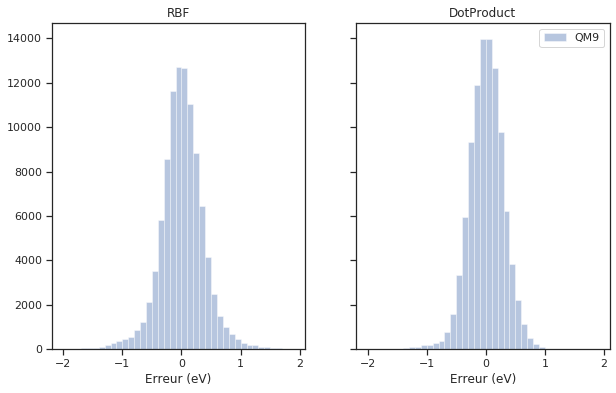

In [35]:
plot_intramodel_error(QM9_results)

In [178]:
def eval_model(model, X_train, y_train, X_test, y_test, size):
    
    tstart = time.time()
    model.fit(X_train[:size], y_train[:size])
    fit_time = time.time() - tstart
    
    tstart = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - tstart
    
    MAE = np.mean(np.absolute(y_pred - y_test))
    
    return MAE, fit_time, predict_time
    

def data_efficiency_experiments(kernels, QM9_smiles):
    
    output_dict = {kernel[0]: {
        "size": [],
        "QM9_fit_time": [],
        "QM9_predict_time": [],
        "QM9_MAE": [],
    } for kernel in kernels}
    
    dataset_sizes = [10, 100, 1000, 10000]
    
    
    desc_builder_shingles = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    desc_builder_mbtr = MBTRDesc(cache_location=None, n_jobs=N_JOBS, cosine_angles_n=25, atomic_numbers_n=10, 
                                 inverse_distances_n=25, species=["C", "H", "O", "N", "F"], 
                                 MM_program="rdkit")
    
    eval_strat = OPTEvaluationStrategy("homo", n_jobs=2, cache_files=[json_cache_location], 
                                     working_dir_path=dft_path, MM_program="rdkit")
    
    
    QM9_train_smiles, QM9_test_smiles = train_test_split(QM9_smiles, test_size=50000)
#     ChEMBL_train_smiles, ChEMBL_test_smiles = train_test_split(ChEMBL_smiles, test_size=50000)
    
    QM9_train_smiles = QM9_train_smiles[:10000]
#     ChEMBL_train_smiles = ChEMBL_train_smiles[:10000]
    
    QM9_train_y = [eval_strat.eval_smi(smi) for smi in tqdm(QM9_train_smiles)]
    QM9_test_y = [eval_strat.eval_smi(smi) for smi in tqdm(QM9_test_smiles)]
#     ChEMBL_train_y = [eval_strat.eval_smi(smi) for smi in tqdm(ChEMBL_train_smiles)]
#     ChEMBL_test_y = [eval_strat.eval_smi(smi) for smi in tqdm(ChEMBL_test_smiles)]
    
    for kernel in kernels:
        print(kernel[0])
        model = GaussianProcessRegressor(kernel=kernel[1], normalize_y=False, alpha=1e-1)

        if kernel[0] == "RBF":
            desc_builder = desc_builder_mbtr
        elif kernel[0] == "DotProduct":
            desc_builder = desc_builder_shingles

        QM9_train_X = desc_builder.fit_transform(QM9_train_smiles)[0]
        QM9_test_X = desc_builder.fit_transform(QM9_test_smiles)[0]
        
        for dataset_size in dataset_sizes:
            print(dataset_size)

            
            MAE_QM9, time_fit_QM9, time_predict_QM9 = eval_model(model, QM9_train_X, QM9_train_y, 
                                                                 QM9_test_X, QM9_test_y, 
                                                                 dataset_size)

            output_dict[kernel[0]]["size"].append(dataset_size)
            output_dict[kernel[0]]["QM9_fit_time"].append(time_fit_QM9)
            output_dict[kernel[0]]["QM9_predict_time"].append(time_predict_QM9)
            output_dict[kernel[0]]["QM9_MAE"].append(MAE_QM9)

            
    return output_dict
            

In [179]:
output_data_efficiency = data_efficiency_experiments(kernels, QM9_smiles)

MM program : obabel_mmff94
None
MM program : rdkit
species MBTR  : ['C', 'H', 'O', 'N', 'F']
atomic_numbers_n : 10
inverse_distances_n : 25
cosine_angles_n : 25


  4%|▎         | 367/10000 [00:00<00:02, 3663.31it/s]

DFT MM rdkit
133798 molecules in cache


  0%|          | 0/10000 [00:00<?, ?it/s]

RBF


100%|██████████| 50000/50000 [08:29<00:00, 98.23it/s] 


10
100
1000
10000


  0%|          | 0/10000 [00:00<?, ?it/s]

DotProduct


100%|██████████| 50000/50000 [02:10<00:00, 382.92it/s]


10
100
1000
10000


In [180]:
with open(join(output_data_path, "data_efficiency_results.json"), "w") as f:
    json.dump(output_data_efficiency, f)

In [181]:
def time_desc(QM9_smiles):
        
    desc_builder_shingles = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    desc_builder_mbtr = MBTRDesc(cache_location=None, n_jobs=1, cosine_angles_n=25, atomic_numbers_n=10, 
                                 inverse_distances_n=25, species=["C", "H", "O", "N", "F"], 
                                 MM_program="rdkit")
    
    _, QM9_test_smiles = train_test_split(QM9_smiles, test_size=50000)
    
    tstart = time.time()
    desc_builder_mbtr.fit_transform(QM9_test_smiles)
    time_mbtr_desc = time.time() - tstart
    
    tstart = time.time()
    desc_builder_shingles.fit_transform(QM9_test_smiles)
    time_shingles_desc = time.time() - tstart
    
    return time_mbtr_desc, time_shingles_desc

In [182]:
# time_mbtr_desc, time_shingles_desc= time_desc(QM9_smiles)

In [183]:
time_mbtr_desc/50

82.09350363731384

In [184]:
time_shingles_desc/50

2.655337414741516

In [185]:
time_mbtr_desc = 82.09350363731384*50

In [186]:
time_shingles_desc = 2.655337414741516*50

In [196]:
import numpy as np
import pandas as pd
from os.path import join



def plot_data_efficiency(output_data_efficiency, time_mbtr_desc, time_shingles_desc):
    
    d = {"sizecol": [], "Données": [], "predict_time": [], "desc_predict_time": [], "fit_time": [], "MAE": [], 
         "Modèle GPR": []} 
    
    k = "RBF"
    
    predict_time_denominateur = 50
    
    for k in ["RBF", "DotProduct"]:
        
        if k == "RBF":
            curr_time_desc = time_mbtr_desc
            name = "RBF, MBTR"
        elif k == "DotProduct":
            curr_time_desc = time_shingles_desc
            name = "DotProduct, shingles"
        
        d["sizecol"].extend(output_data_efficiency[k]["size"])
        d["Données"].extend(np.full(len(output_data_efficiency[k]["size"],), "QM9"))
        d["Modèle GPR"].extend(np.full(len(output_data_efficiency[k]["size"],), name))
        d["fit_time"].extend(output_data_efficiency[k]["QM9_fit_time"])
        d["predict_time"].extend(np.array(output_data_efficiency[k]["QM9_predict_time"])/predict_time_denominateur)
        d["desc_predict_time"].extend(np.array(output_data_efficiency[k]["QM9_predict_time"])/predict_time_denominateur + curr_time_desc/predict_time_denominateur)
        d["MAE"].extend(output_data_efficiency[k]["QM9_MAE"])

        
    df = pd.DataFrame.from_dict(d)
    df = df[df.sizecol != 30]
    df = df[df.sizecol != 300]
    df = df[df.sizecol != 3000]


   
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=df, x="sizecol", y="MAE", hue="Modèle GPR", legend="brief")
    plt.ylabel("Erreur moyenne absolue (MAE)")
    plt.xlabel("Taille des données d'entraînement")
    plt.xscale("log")
#     plt.yscale("log")
    plt.ylim(0, 0.8)
    
    plt.savefig(join(output_fig_path, "HOMO_MAE.png"), dpi=250)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6), sharex=True) #sharey=True)

    
#     handles, labels = ax1.get_legend_handles_labels()
#     ax1.legend(handles=handles[:2], labels=labels, title="Whatever else")
#     ax1.legend(handles=handles[2:4], labels=labels, title="Whatever else")
    

    sns.lineplot(x="sizecol", y="fit_time", hue="Modèle GPR", data=df[df["Données"] == "QM9"], ax=ax1, legend=False)
    sns.lineplot(x="sizecol", y="predict_time", hue="Modèle GPR", data=df[df["Données"] == "QM9"], ax=ax2, legend=False)
    sns.lineplot(x="sizecol", y="desc_predict_time", hue="Modèle GPR", data=df, ax=ax3)
    
    ax1.set_xlabel("Taille des données d'entraînement")
    ax1.set_ylabel("Temps (s)")
    ax1.set_yscale("log")
    ax1.set_xscale("log")
    ax1.set_ylim(1e-3, 1e4)
    ax1.set_title("Entraînement")
    
    ax2.set_xlabel("Taille des données d'entraînement")
    ax2.set_ylabel("")
    ax2.set_yscale("log")
    ax2.set_xscale("log")
    ax2.set_ylim(1e-3, 1e4)
    ax2.set_title("Prédiction (1000 mol.)")
    
    ax3.set_xlabel("Taille des données d'entraînement")
    ax3.set_ylabel("")
    ax3.set_yscale("log")
    ax3.set_xscale("log")
    ax3.set_ylim(1e-3, 1e4)
    ax3.set_title("Descripteurs + prédiction (1000 mol.)")
    ax3.legend(loc="lower right")
    
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(join(output_fig_path, "HOMO_times.png"), dpi=250)
    
    return df

sizecol Données  predict_time  desc_predict_time     fit_time       MAE  \
0       10     QM9      0.015585          82.109089     0.008481  0.710192   
1      100     QM9      0.121281          82.214785     0.134319  0.351614   
2     1000     QM9      1.434956          83.528460    10.829057  0.270668   
3    10000     QM9     15.120585          97.214089  1284.825927  0.227876   
4       10     QM9      0.002996           2.658333     0.010611  0.580155   
5      100     QM9      0.005703           2.661040     0.028047  0.321749   
6     1000     QM9      0.025764           2.681101     1.245048  0.230039   
7    10000     QM9      0.315973           2.971311   233.636931  0.212592   

             Modèle GPR  
0             RBF, MBTR  
1             RBF, MBTR  
2             RBF, MBTR  
3             RBF, MBTR  
4  DotProduct, shingles  
5  DotProduct, shingles  
6  DotProduct, shingles  
7  DotProduct, shingles

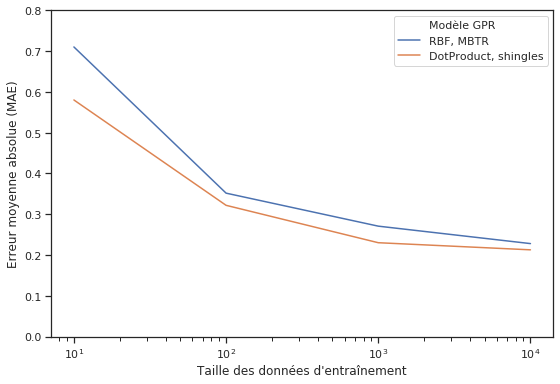

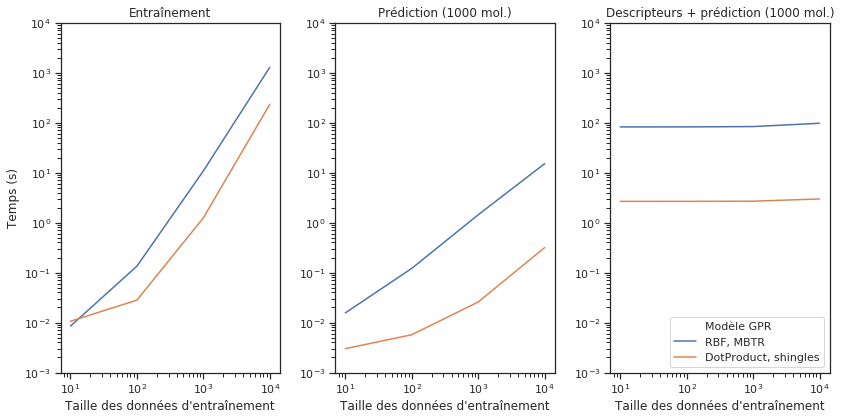

In [197]:
plot_data_efficiency(output_data_efficiency, time_mbtr_desc, time_shingles_desc)

In [189]:
output_data_efficiency

{'RBF': {'size': [10, 100, 1000, 10000],
  'QM9_fit_time': [0.00848078727722168,
   0.13431906700134277,
   10.829057216644287,
   1284.8259272575378],
  'QM9_predict_time': [0.779245138168335,
   6.064050674438477,
   71.74779772758484,
   756.0292625427246],
  'QM9_MAE': [0.7101924356375403,
   0.3516137191573325,
   0.2706683092895171,
   0.22787589219543083]},
 'DotProduct': {'size': [10, 100, 1000, 10000],
  'QM9_fit_time': [0.01061105728149414,
   0.02804708480834961,
   1.2450482845306396,
   233.63693141937256],
  'QM9_predict_time': [0.1497795581817627,
   0.2851378917694092,
   1.288177251815796,
   15.798674583435059],
  'QM9_MAE': [0.5801551304156021,
   0.3217491142894206,
   0.23003937842780667,
   0.21259186727502846]}}